# Inference Code

This notebook loads one of the fine-tuned models and runs inference on every nucleotide sequence. In our case, we used the fine-tuned [ErnieRNA](https://huggingface.co/timothytran/FineTuned_RNAModels_for_BranchPoint_Prediction/tree/main/multimolecule-ernierna-finetuned/final_model), our best performing model. Since the max input size of this model is 1024, for any sequences longer than this model, we split it into chunks, run inference on those chunks, and concatenate the generated probabilites to get a single probability for each nucleotide in the sequence.

In [23]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [24]:
import os
import pandas as pd
import torch
from transformers import (
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from google.colab import drive

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')

WORKING_DIRECTORY = '/content/drive/MyDrive/INPUT_FOLDER_NAME'
DATASET_PATH = 'INPUT_LOCATION_OF_DATA'

%cd {WORKING_DIRECTORY}

os.environ["WANDB_MODE"] = "disabled"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/epfl_ml_project
Using device: cuda


## Choose the model to run inference

In [26]:
from multimolecule import (
    RnaTokenizer,
    ErnieRnaForTokenPrediction,
    ErnieRnaConfig
)

# Define configuration
config = ErnieRnaConfig()
config.problem_type = "single_label_classification"
config.num_labels = 2

# Define constants
MODEL_MAX_INPUT_SIZE = 1024
model_folder = f"finetuned-ernie-final/"

# Load model and tokenizer
trained_model = ErnieRnaForTokenPrediction.from_pretrained(model_folder, config=config)
tokenizer = RnaTokenizer.from_pretrained(model_folder)

## Dataset generation
Due to dataset generation time, we've modified the notebook to only generate probabilites for 10,000 sequences at a time. To run this on a dataset of >10,000 sequences, rerun this notebook starting at 1 until you've generated probabilites for every sequence. A CSV is generated for each chunk of 10,000.

This can be easily automated in a for-loop.

In [27]:
# Load dataset
full_df = pd.read_csv(DATASET_PATH, sep='\t')
DATAFRAME_SECTION = 10 # 1 indexed
DATAFRAME_CHUNCK_SIZE = 10000
df = full_df.iloc[(DATAFRAME_SECTION - 1) * DATAFRAME_CHUNCK_SIZE : DATAFRAME_SECTION * DATAFRAME_CHUNCK_SIZE]


In [28]:
"""
This is the code that splits the data in chunks, makes predictions, and puts
the predictions together.

All of these methods are modifications of the original scripts from
https://github.com/AliSaadatV/BP_LM/tree/main/scripts.

"""

# Data preprocessing
def extract_intron_seq_and_labels(df, chunk_size):
    """
    Splits sequences into fixed-size chunks and creates binary labels. Labels are 1 at the branch point position and 0 elsewhere.
    """
    ivs_sequences = df['IVS_SEQ'].tolist()
    bp_positions = df['BP_POS_WITHIN_STRAND'].tolist()

    processed_sequences = []
    processed_labels = []
    chunk_mappings = []

    for orig_idx, (sequence, bp_pos) in enumerate(zip(ivs_sequences, bp_positions)):
        seq_len = len(sequence)
        for offset in range(0, seq_len, chunk_size):
            chunk = sequence[offset:offset + chunk_size]
            chunk_len = len(chunk)
            if offset <= bp_pos < offset + chunk_len:
                label = [0] * (bp_pos - offset) + [1] + [0] * (chunk_len - (bp_pos - offset) - 1)
            else:
                label = [0] * chunk_len

            processed_sequences.append(chunk)
            processed_labels.append(label)
            chunk_mappings.append((orig_idx, offset, chunk_len))

    return processed_sequences, processed_labels, chunk_mappings

def create_dataset(df, tokenizer, chunk_size, seed, sample_n_datapoints):
    """
    Creates a tokenized dataset with fixed-length chunks. Optionally samples a subset of the data.
    """
    if sample_n_datapoints:
        df = df.sample(n=sample_n_datapoints, random_state=seed)

    df = df.copy()
    df['BP_POS_WITHIN_STRAND'] = df['IVS_SIZE'] + df['BP_ACC_DIST']

    sequences, labels, mappings = extract_intron_seq_and_labels(df, chunk_size)

    tokenized = tokenizer(
        sequences,
        padding='max_length',
        truncation=True,
        max_length=chunk_size,
        return_tensors='pt'
    )

    dataset = Dataset.from_dict(tokenized)
    return dataset.add_column("labels", labels).add_column("mapping", mappings), sequences


# Metrics
def compute_sequence_accuracy(predictions, labels):
    """
    Calculate the exact match accuracy between predicted and true labels across sequences.
    """
    correct = sum(np.array_equal(pred, lab) for pred, lab in zip(predictions, labels))
    return (correct / len(predictions) * 100) if predictions else 0.0

# Probability extraction
def get_logits(trainer, dataset):
    """
    Obtains logits for the evaluation dataset.
    """
    trainer.model.eval()
    dataloader = trainer.get_eval_dataloader(dataset)
    logits_list, labels_list = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):

            batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
            outputs = trainer.model(**batch)
            logits_list.append(outputs.logits.cpu().numpy())
            labels_list.append(batch['labels'].cpu().numpy())

    return np.concatenate(logits_list), np.concatenate(labels_list)

def aggregate_chunks(logits, labels, sequences, mapping):
    """
    Reconstructs full sequences from chunked predictions using the provided mapping.
    """
    aggregated_data = defaultdict(lambda: {'logits': [], 'labels': [], 'sequences': []})

    for idx, (orig_id, offset, chunk_len) in enumerate(mapping):
        aggregated_data[orig_id]['logits'].append((offset, logits[idx][:chunk_len]))
        aggregated_data[orig_id]['labels'].append((offset, labels[idx][:chunk_len]))
        aggregated_data[orig_id]['sequences'].append((offset, sequences[idx][:chunk_len]))

    sorted_ids = sorted(aggregated_data.keys())
    aggregated_logits = [
        np.concatenate([logit for _, logit in sorted(aggregated_data[id]['logits'], key=lambda x: x[0])])
        for id in sorted_ids
    ]
    aggregated_labels = [
        np.concatenate([label for _, label in sorted(aggregated_data[id]['labels'], key=lambda x: x[0])])
        for id in sorted_ids
    ]
    aggregated_sequences = [
        "".join([sequence for _, sequence in sorted(aggregated_data[id]['sequences'], key=lambda x: x[0])])
        for id in sorted_ids
    ]
    return aggregated_logits, aggregated_labels, aggregated_sequences

def softmax(x, axis=-1):
    x_exp = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return x_exp / np.sum(x_exp, axis=axis, keepdims=True)

def extract_probabilities(aggregated_logits):
    """
    Converts aggregated prediction logits into probabilities for each NT.
    """
    class_1_probs_list = []

    for seq_logits in aggregated_logits:
        softmaxed_seq_logits = np.exp(seq_logits[:, 1] - np.max(seq_logits[:, 1])) # Subtract max for numerical stability
        class_1_probs_list.append(softmaxed_seq_logits / np.sum(softmaxed_seq_logits))

    return class_1_probs_list

def classify_sequences(class_1_probs_list):
    classifications = []

    for class_1_probs in class_1_probs_list:
        max_prob_position = np.argmax(class_1_probs)
        pred = np.zeros_like(class_1_probs, dtype=int)
        pred[max_prob_position] = 1
        classifications.append(pred)

    return classifications

# Histogram plotting
def plot_accuracy_vs_sequence_length(predictions, true_labels, chunk_size):
    """
    Plots a histogram of sequence-level accuracy binned by sequence length
    """
    bin_data = defaultdict(lambda: {"correct": 0, "total": 0})
    for pred, lab in zip(predictions, true_labels):
        seq_len = len(lab)
        bin_lower = (seq_len // chunk_size) * chunk_size
        is_correct = int(np.array_equal(pred, lab))
        bin_data[bin_lower]["correct"] += is_correct
        bin_data[bin_lower]["total"] += 1


    sorted_bins = sorted(bin_data.items())
    bin_labels = [f"{k}-{k + chunk_size - 1}" for k, _ in sorted_bins]
    bin_centers = [k + chunk_size / 2 for k, _ in sorted_bins]
    accuracies = [v["correct"] / v["total"] * 100 for _, v in sorted_bins]
    counts = [v["total"] for _, v in sorted_bins]


    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(bin_centers, accuracies, width=chunk_size * 0.8, align='center', alpha=0.7)
    ax.set_xlabel("Sequence Length Bin")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Sequence-Level Accuracy vs Total Sequence Length")

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'n={count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    ax.set_xticks(bin_centers)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [29]:
# Configuration Constants
CHUNK_SIZE = 1024    # Important, this is set at 1024, 512 works but worse results for sequences under from 512 to 1024 length
MODEL_MAX_INPUT_SIZE = 1024
SAMPLE_N_DATAPOINTS = None # Can be set to a small number for testing purposes
SEED = 10
BATCH_SIZE = 64 # Experiment a bit with this before the final run, check VRAM usage. I think we'll be able to go with 64 or more

# Filter the dataframe to include only sequences within a given length range.
# MAX_LENGTH, MIN_LENGTH = 3 * MODEL_MAX_INPUT_SIZE, 0 * MODEL_MAX_INPUT_SIZE
# short_df = df.loc[(df['IVS_SEQ'].str.len() < MAX_LENGTH) &
#                   (df['IVS_SEQ'].str.len() > MIN_LENGTH)]

# Create the test dataset
test_dataset, chunked_sequences = create_dataset(df, tokenizer, chunk_size=CHUNK_SIZE, seed = SEED, sample_n_datapoints = SAMPLE_N_DATAPOINTS)
data_collator = DataCollatorForTokenClassification(tokenizer)

In [30]:
# Set up training
training_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="steps",
    no_cuda=False,
)

trainer = Trainer(
    model=trained_model,
    args=training_args,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Obtain logits, probabilities and labels
chunked_logits, chunked_labels = get_logits(trainer, test_dataset)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-5357a4667c08>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating:   0%|          | 0/968 [00:00<?, ?it/s]

Sequence-level accuracy: 55.35%
Correct predictions: 5535/10000


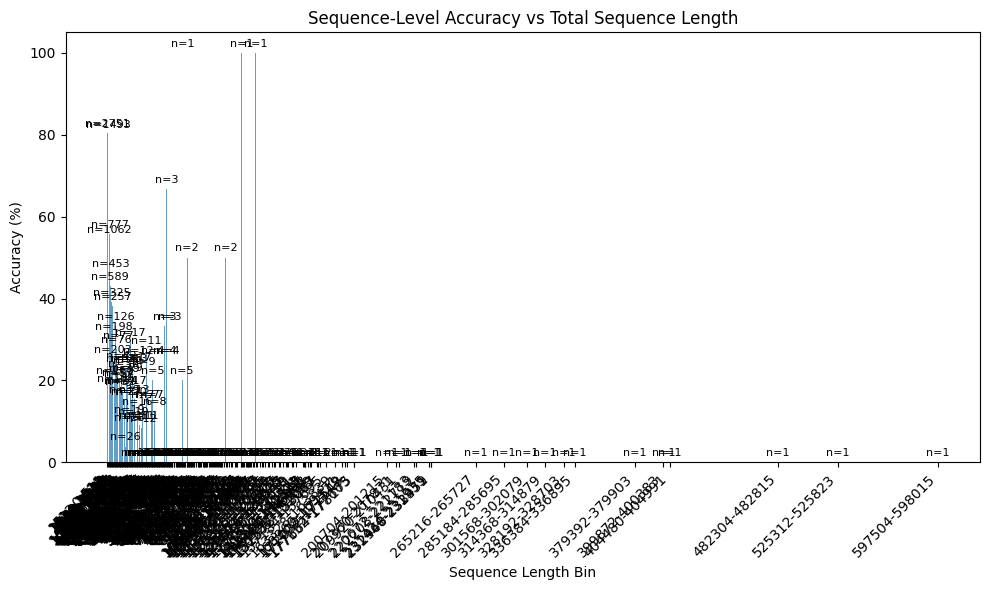

In [31]:
agg_logits, agg_labels, agg_sequences = aggregate_chunks(chunked_logits, chunked_labels, chunked_sequences, test_dataset['mapping'])
agg_probabilities = extract_probabilities(agg_logits)
predictions = classify_sequences(agg_probabilities)

# Compute Seq. Acc
accuracy = compute_sequence_accuracy(predictions, agg_labels)
print(f"Sequence-level accuracy: {accuracy:.2f}%")
print(f"Correct predictions: {int(accuracy * len(predictions) / 100)}/{len(predictions)}")

# For the histogram plot
plot_accuracy_vs_sequence_length(predictions, agg_labels, chunk_size=CHUNK_SIZE // 2)

In [32]:
def build_sequence_probability_table(ivs_seq_list, probability_list_999):
    """
    This creates a CSV file with just the sequences and the probabilities for each NT.
    """
    # NOTE: Model outputs the probability list of length 999, so we only take the last part of the probability list
    probability_list = [prob[:len(seq)] for prob, seq in zip(probability_list_999, ivs_seq_list)]

    # Ensure lengths match
    for seq, probs in zip(ivs_seq_list, probability_list):
        if len(seq) != len(probs):
            print(f"len of seq: {len(seq)}")
            print(f"len of probs: {len(probs)}")
            raise ValueError(f"Length of sequence '{seq}' does not match length of corresponding probabilities.")

    # Create a DataFrame, concatenate probabilites using an underscore
    df = pd.DataFrame({
        "Sequence": ivs_seq_list,
        "Probabilities": ["_".join([f"{x:.4f}" if abs(x) > 1e-3 else "0" for x in probs]) for probs in probability_list]
    })

    return df

# seq_probs_df = build_sequence_probability_table(agg_sequences, agg_probabilities)
# print(seq_probs_df)

# # Save DataFrame to a CSV file
# seq_probs_df.to_csv("sequence_probabilities.csv", index=False)

## Append the probabilties to the original dataframe

In [33]:
def append_probabilities_to_df(df, ivs_seq_list, probability_list):
    # Ensure the sequences in the DF and the sequence list are the same
    for i in range(len(df)):
        if df.iloc[i]['IVS_SEQ'] != ivs_seq_list[i]:
            raise ValueError(f"Sequences of the DF and sequence list do not match")

    probability_list = [prob[:len(seq)] for prob, seq in zip(probability_list, ivs_seq_list)]

    # Ensure lengths match
    for seq, probs in zip(ivs_seq_list, probability_list):
        if len(seq) != len(probs):
            print(f"len of seq: {len(seq)}")
            print(f"len of probs: {len(probs)}")
            raise ValueError(f"Length of sequence '{seq}' does not match length of corresponding probabilities.")

    # Create a DataFrame, concatenate probabilites using an underscore
    df["Probabilities"] = ["_".join([f"{x:.4f}" if abs(x) > 1e-3 else "0" for x in probs]) for probs in probability_list]

    return df

new_df_with_probabilities = append_probabilities_to_df(df, agg_sequences, agg_probabilities)

# Save DataFrame to a CSV file
new_df_with_probabilities.to_csv(f"sequence_probabilities_{DATAFRAME_SECTION}.csv", index=False)

<ipython-input-33-df92ac61d54d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Probabilities"] = ["_".join([f"{x:.4f}" if abs(x) > 1e-3 else "0" for x in probs]) for probs in probability_list]
